In [4]:
# check requirements
# !pip install cmake 'gym[atari]' scipy

import gym 
import pygame
from IPython.display import clear_output,display
from time import sleep
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_path = '../Data/'

%matplotlib inline

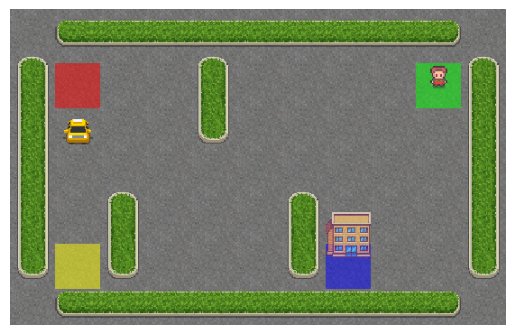

In [17]:
env = gym.make("Taxi-v3",render_mode='rgb_array').env 
env.reset()
frame = env.render() 
plt.imshow(frame)
plt.axis('off')
plt.show() 
# env.render()
# rules: https://gym.openai.com/envs/Taxi-v3/

# State of the game
Location of taxi, Location of passenger, Location of home 

# Action 
up, down, left, right, pickup, dropoff

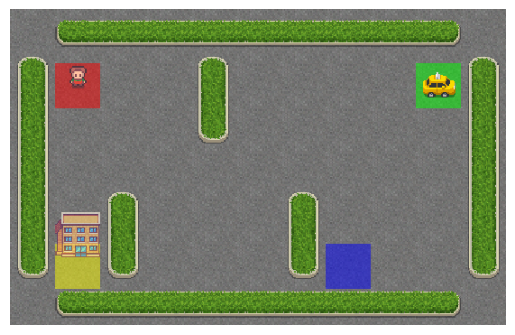

Experience:
state : 62
action: 2
reward: -1
next state: 82


KeyboardInterrupt: 

In [20]:
# random agent driving 
state , done = env.reset()[0], False

# t is the step in the game 
for t in range(100):
    
    # start by taking a random action 
    action = env.action_space.sample() 
    
    # get new state and reward
    # Envrionment takes in an action and spits out 1. new state and 2. reward 
    newstate, reward, done, truncated, _ = env.step(action) 
    
    # output
    # draw the new state 
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    print('Experience:')
    print('state : %d' % state)
    print('action: %d' % action)
    print('reward: %d' % reward)
    print('next state: %d' % newstate)
    sleep(5)
    
    state = newstate

In [34]:
env = gym.make("Taxi-v3").env 
# env.seed(34)
Q = np.zeros((env.observation_space.n,env.action_space.n))

# random probability of exploration 
epsilon = 0.1
# discount factor 
gamma = 0.9
# learning rate 
alpha = 0.1

for episode in range(10000):
    
    if (episode+1) % 500 == 0:
        print('episode %d' % (episode+1))
    
    state = env.reset()[0]
    done = False 

    while not done:

        if np.random.uniform() < epsilon:
        
            action = env.action_space.sample()
        
        else:
            
            # iterate through the row of the Q in that state
            # pick the action that has the max reward 
            action = np.argmax(Q[state,])
        
        # get new state and reward
        newstate, reward, done, _ , _ = env.step(action) 

        # update
        y = reward + 0.9 * np.max(Q[newstate])
    
        Q[state,action] += alpha * ( y -  Q[state,action] )

        state = newstate

episode 500
episode 1000
episode 1500
episode 2000
episode 2500
episode 3000
episode 3500
episode 4000
episode 4500
episode 5000
episode 5500
episode 6000
episode 6500
episode 7000
episode 7500
episode 8000
episode 8500
episode 9000
episode 9500
episode 10000


In [39]:
# trained agent driving
# env.seed(484) 
state = env.reset()[0]
done = False
while not done:    
    # optimal action
    action = np.argmax(Q[state])
    
    # get new state and reward
    state, reward, done, _ , _ = env.step(action)
    
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    # env.render()
    sleep(5)

AssertionError: Something went wrong with pygame. This should never happen.

# Portfolio problem

In [8]:
df = pd.read_csv(data_path + '/mkt_rf_dp.csv')

# excess return
df['RetEx'] = df['Ret'] - df['Rfree']

# lag dp ratio by a year
df['D/P lag'] = df['D/P'].shift(12)

# merton myopic strategy 
roll = np.log(1+df['Ret']).shift(1).rolling(240)
mu, sigma2 = roll.mean(), roll.var()
df['merton'] = (mu + 0.5*sigma2 - np.log(1+df['Rfree'])) / sigma2

# binary signal
roll = df['D/P lag'].rolling(240)
df['signal'] = (df['D/P lag'] > roll.median()).astype('int')

df

,yyyymm,Ret,Rfree,D/P,RetEx,D/P lag,merton,signal
0,187102,0.013514,0.004525,-2.851151,0.008989,NaN,NaN,0
1,187103,0.024444,0.004252,-2.875302,0.020193,NaN,NaN,0
2,187104,0.028200,0.004643,-2.903111,0.023557,NaN,NaN,0
3,187105,0.025316,0.003698,-2.928112,0.021618,NaN,NaN,0
4,187106,-0.008230,0.003373,-2.919848,-0.011604,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1782,201908,-0.018092,0.001625,-3.941330,-0.019717,-4.023875,1.461082,0
1783,201909,0.017181,0.001575,-3.951689,0.015606,-4.019533,1.460247,0
1784,201910,0.020432,0.001375,-3.965984,0.019057,-3.938669,1.678299,1
1785,201911,0.034047,0.001283,-3.993568,0.032764,-3.947516,1.643723,1


<Axes: >

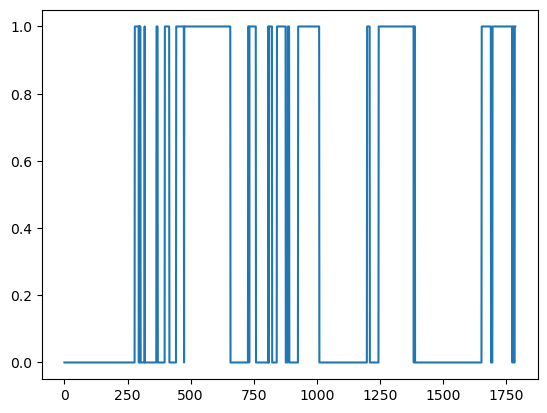

In [9]:
df['signal'].plot()

/var/folders/df/x7ngsr_15bx8pln6jsqgdxy00000gn/T/ipykernel_56198/1351285385.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,x='signal',y='RetEx',ci=None)


<Axes: xlabel='signal', ylabel='RetEx'>

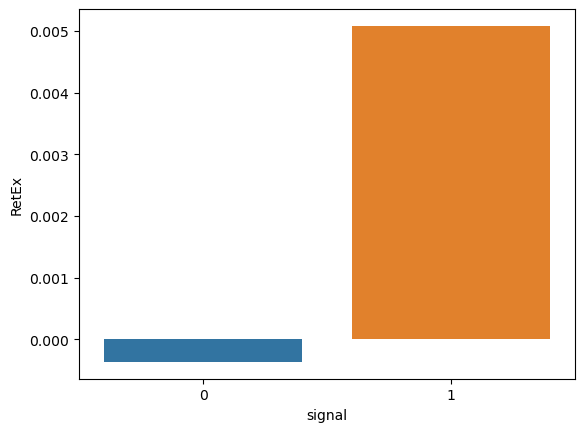

In [10]:
sns.barplot(data=df,x='signal',y='RetEx',ci=None)

In [11]:
df.dropna().to_csv(data_path + '/merton_signal.csv')

In [12]:
import gym
import numpy as np
from gym import error, spaces, utils
from gym.utils import seeding
import pandas as pd
import os

class MertonLogSignal(gym.Env):

    def __init__(self,horizon=12):
        
        # economic parameters
        self.horizon = horizon 
        
        # markov problem
        self.observation_space=spaces.Discrete(2) 
        self.action_space=spaces.Discrete(3)
        
        # data
        self.data = pd.read_csv(data_path + '/merton_signal.csv')  
        

    def step(self, action):
        
        # portfolio
        self.merton = self.data['merton'].iloc[self.date]
        self.port =  self.merton + (action-1) * 0.5
        
        # returns next period
        Rf = self.data['Rfree'].iloc[self.date]
        Re = self.data['RetEx'].iloc[self.date]

        # log return
        self.rp = np.log(1 + Rf + self.port * Re)
        
        # housekeeping
        self.date += 1
        self.life -= 1
        self.dp = self.data['signal'].iloc[self.date]
        
        # output: state, reward, done, info
        return self.dp, self.rp, self.life == 0, {}
        

    def reset(self):
        # wealth
        self.wealth = 100
        
        # time
        self.date = np.random.choice(len(self.data)-self.horizon) # birthday 
        self.life = self.horizon # periods of life left
        
        # dp
        self.dp = self.data['signal'].iloc[self.date]
        
        return self.dp
        

    def render(self):
        print('Date: %s\n' % self.data['yyyymm'].iloc[self.date])
        print('Merton: %.2f\n' % self.merton)
        print('RoboMerton: %.2f\n' % self.port)

In [13]:
# random agent investing
env = MertonLogSignal()
state , done = env.reset(), False
for i in range(10):
    
    # random action
    action = env.action_space.sample() 
    
    # get new state and reward
    state, reward, done, info = env.step(action) 
        
    clear_output(wait=True)
    env.render()
    sleep(5)

Date: 198401

Merton: -1.82

RoboMerton: -1.32



In [14]:
%matplotlib inline
# Q learning
env = MertonLogSignal()
env.seed(34)
Q = np.zeros([env.observation_space.n, env.action_space.n])

for ep in range(50000):
    
    if (ep+1) % 10000 == 0:
        print('episode %d' % (ep+1))
        plt.figure()
        plt.plot(Q.T)
        plt.legend(['signal = 0','signal = 1'])
        plt.title('Q after Episode %d\n' % (ep+1))

    
    # initialise episode
    state , done = env.reset(), False
    
    # set learning rate and exploration parameters
    alpha = 1e-2 if ep < 10000 else 1e-3
    epsilon = 1 if ep < 50000 else 0.1
    
    while not done:
        
        # choose action using epsilon greedy
        if np.random.uniform() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
            
        # draw new state and reward
        newstate, reward, done, info = env.step(action) 
        
        # target / update
        y = reward + np.max(Q[newstate])
        Q[state,action] -=  alpha * (Q[state,action]-y)
        
        state = newstate

AttributeError: 'MertonLogSignal' object has no attribute 'seed'